# Solving poisson's equation

Coordinate system has x out of the page, y up and z across. Capacitor plates are vertical. The sphere is always at 0,0 in the middle. Movement of the sphere is modelled rather as movement of the plates.

The potential is captured using the $\phi$ grid. The charge is on a "charge" grid. The total charge is spread uniformly over the surface of the sphere. The plates are held at a potential + and - V/2.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import convolve, generate_binary_structure

In [21]:
#Define grid and plate physical dimensions
L_box = 0.25
N = 101#num grid points per dimension

dx=L_box/(N-1) # Grid point spacing, assume symmetric.
print(f"grid spacing {dx}")
dR = np.sqrt(3)*dx # dR is the shell thickness for finding pixels that are at the surface to add charge to.

#plates
L_plate = 0.1
D_plate = 0.13
V_plate = 2000
t_plate = 0.002

#Sphere
R_sphere = 0.005
Q = 3E-9
dz=0.0 # dz needs to be a whole number of grid points. Enter a value and it will change it to the nearest value

dz = dx*int(dz/dx)
print(f"using dz = {dz}")

#Turn features on and off
plates = False
ball = True

#How many iterations to perform of minimisation
iters = 3000

#Constants
eps0 = 8.854E-12

mask = np.zeros((N,N,N))

grid spacing 0.0025
using dz = 0.0


In [22]:
lh_plate = {'Ltop': L_plate/2,'Lbottom':-L_plate/2, 'Z': -D_plate/2, 't':t_plate, 'V': +V_plate/2}
rh_plate = {'Ltop': L_plate/2, 'Lbottom':-L_plate/2, 'Z': +D_plate/2, 't':t_plate,  'V': -V_plate/2}
ball = {'R':R_sphere, 'Q':Q, 'dR': dR}
sim = {'Lbox':L_box,'N':N, 'dx':dx, 'dz':dz, 'dz':dz, 'iters':iters, 'plates':True, 'ball':True}

In [23]:
def abscoord_to_grididx(displacement, sim):
    #converts absolute coord assuming (0,0) at centre of box to a phi grid index
    value = int(0.5+(sim['Lbox']/2 + displacement - sim['dz'])/sim['dx'])
    return value

## Create the plate regions

In [24]:
"""Two plates at potential V/2 and -V/2 in a box
phi keeps track of the potential
"""
def define_plate_mask(plate):
    """Create a mask indicating where a plate is in the grid"""
    N=sim['N']
    grid = np.zeros((N,N,N))
    plate_bottom = abscoord_to_grididx(plate['Lbottom'], sim)
    plate_top = abscoord_to_grididx(plate['Ltop'], sim)
    plate_pos = abscoord_to_grididx(plate['Z'], sim)

    #x,y,z
    grid[plate_bottom:plate_top, plate_bottom:plate_top, plate_pos] = 1
    mask = grid==1
    return mask

if plates:
    mask_pos = define_plate_mask(lh_plate)
    mask_neg = define_plate_mask(rh_plate)

## Create the charged ball

In [25]:
def find_charge_coords(ball, sim):
    R=ball['R']
    dR=ball['dR']
    N=sim['N']

    #Works out which pixels are at the surface of sphere. ie between R and R+dR.
    coords=[]
    dist=[]

    lower_bound = abscoord_to_grididx(-(R+dR), sim)
    upper_bound = abscoord_to_grididx(+(R+dR), sim)
    print(R, dR, lower_bound, upper_bound)

    for i in range(lower_bound, upper_bound+1):
        for j in range(lower_bound, upper_bound+1):
            for k in range(lower_bound, upper_bound+1):
                dist_2_centre = ((i-N//2)**2 + (j-N//2)**2 + (k-N//2)**2)**0.5
                if (dist_2_centre >= R/dx) and (dist_2_centre < (R+dR)/dx):
                    coords.append((i,j,k))
                    dist.append(dist_2_centre)
    return coords

def charge_ball(ball, sim):
    """Add charge to the surface of the ball"""
    N=sim['N']
    rho = np.zeros((N,N,N))
    
    #Coords of surface charges on ball
    charge_coords = find_charge_coords(ball, sim)

    #Create a matrix of little charges at the surface of sphere
    for charge in charge_coords:
        rho[charge[0], charge[1], charge[2]] = ball['Q']/(len(charge_coords)*sim['dx']**3)

    return rho    

if ball:
    rho=charge_ball(ball, sim)

0.005 0.004330127018922193 46 54


## Functions to apply boundary conditions

In [26]:
def neumann_boundary(grid):
    #Set derivative to zero at boundary of grid
    grid[0,:,:] = grid[1,:,:] 
    grid[-1,:,:] = grid[-2,:,:]
    grid[:,0,:] = grid[:,1,:] 
    grid[:,-1,:] = grid[:,-2,:]
    grid[:,:,0] = grid[:,:,1] 
    grid[:,:,-1] = grid[:,:,-2]
    return grid

def dirichlet_boundary(grid, V):
    """This sets the boundary pixels to the potential V"""
    grid[0,:,:] = V
    grid[:,0,:] = V
    grid[:,:,0] = V
    grid[-1,:,:] = V
    grid[:,-1,:] = V
    grid[:,:,-1] = V
    return grid

def dirichlet(grid, V, mask):
    """This sets the value of the potential to V at the points labelled True in the mask"""
    grid[mask] = V
    return grid

## Solve poisson's equation

In [27]:
def solve_poisson(rho, edge='neumann'):
    """Solves the poisson equation numerically for a 3D grid
    
    rho is the charge distribution
    """
    #Numerically solve
    err = []
    #Create a kernel to do the averaging of neighbours
    kern = generate_binary_structure(3,1).astype(float)/6
    kern[1,1,1] = 0
    grid = np.zeros((N,N,N))

    #iterate towards solution
    for i in range(iters):
        grid_updated = convolve(grid, kern, mode='constant')
        grid_updated += dx**2 * rho / (6 * eps0)
        
        # Boundary conditions zero gradient (neumann)
        if edge == 'neumann':
            grid_updated = neumann_boundary(grid_updated)
        # Boundary condition fixed potential (dirichlet)
        elif edge == 'dirichlet':
            grid_updated = dirichlet_boundary(grid_updated, 0)

        # Boundary conditions (dirchlett)
        if plates:
            grid = dirichlet(grid_updated, +V_plate/2, mask_pos)
            grid = dirichlet(grid_updated, -V_plate/2, mask_neg)
        # See what error is between consecutive arrays
        err.append(np.mean((grid-grid_updated)**2))
        grid = grid_updated
    return grid, err


grid, err = solve_poisson(rho, edge='dirichlet')

In [30]:
def calc_Efield(grid, sim):
    # Compute the Force field
    Ex, Ey, Ez = np.gradient(-grid, sim['dx'])
    E_magnitude = np.sqrt(Ex**2 + Ey**2 + Ez**2)
    return E_magnitude, (Ex, Ey, Ez)

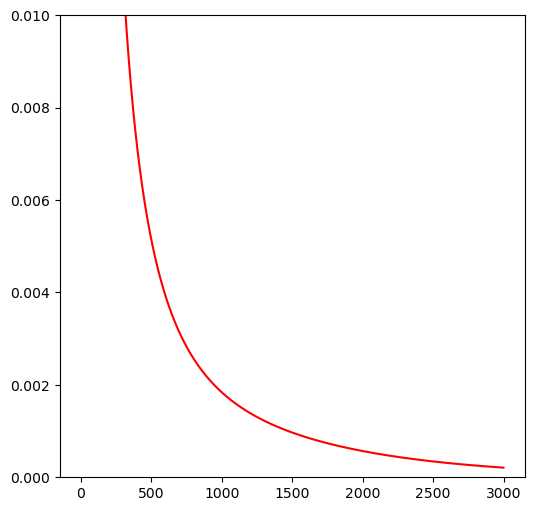

In [28]:
def convergence(err):
    #Check how it is converging
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(range(iters), err,'r-')
    ax.set_ylim(ymin=0, ymax=0.01)
    plt.show()

convergence(err)

C:\Users\ppzmis\AppData\Local\Temp\ipykernel_10764\1525420215.py:40: RuntimeWarning: divide by zero encountered in divide
  ax.plot(rad[rad>ball['R']], (ball['Q']/(4*np.pi*eps0*rad))[rad>ball['R']], 'r--')


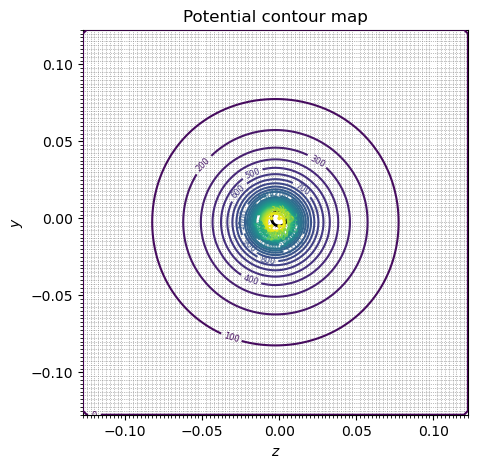

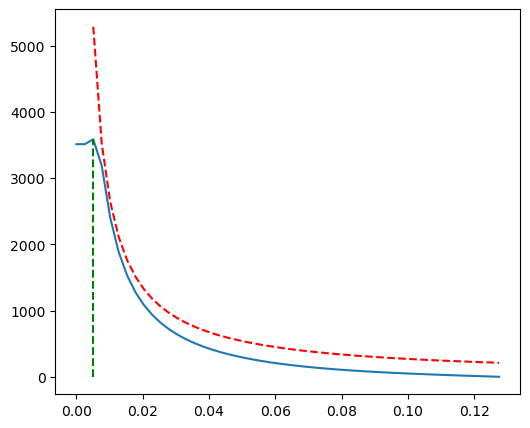

In [29]:
def plot_2Dpotential(grid, sim, zorder=1):
    #Create a contour map of the potential
    # slc specifies the slice in 3D cube to look at in the y-z plane
    fig, ax = plt.subplots(figsize=(6,5))
    #CS = plt.contour([np.arange(-sim['N']//2, sim['N']//2)*sim['dx'] , np.arange(-sim['N']//2, sim['N']//2)*sim['dx']], grid[sim['N']//2], levels=40, zorder=3)
    Z,Y = np.meshgrid(np.arange(-sim['N']//2, sim['N']//2,1)*sim['dx'],np.arange(-sim['N']//2, sim['N']//2,1)*sim['dx'])
    CS = plt.contour(Z,Y, grid[sim['N']//2], levels=40, zorder=3)
    ax.clabel(CS, CS.levels, inline=True, fontsize=6)
    ax.set_title('Potential contour map')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal')
    return ax

def plot_plate(ax, plates, zorder=2):
    plate=Rectangle((plates['Z']- sim['dz'] - plates['t']/2, plates['Lbottom']), plates['t'], plates['Ltop']-plates['Lbottom'],
                                linewidth=1, edgecolor='k', facecolor='r', linestyle='-', zorder=2)
    ax.add_patch(plate)
    return ax

def plot_ball(ax, ball, zorder=2):
    sphere = Circle((0,0), ball['R'], linewidth=2, edgecolor='k', facecolor='w', linestyle='-', zorder=2)
    ax.add_patch(sphere)
    return ax

def plot_grid(ax, sim):
    #Set up grid to match the grid where values are calculated
    ax.xaxis.set_minor_locator(MultipleLocator(sim['dx']))
    ax.yaxis.set_minor_locator(MultipleLocator(sim['dx']))
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
    return ax

def plot_rad_potential(grid, ball, sim):
    fig, ax = plt.subplots(figsize=(6,5))
    potential = grid[sim['N']//2, sim['N']//2, sim['N']//2:]
    rad=np.linspace(0, np.size(potential), num=np.size(potential))*sim['dx']

    ax.plot(rad, potential)
    ax.plot([ball['R'], ball['R']], [0, np.max(potential)], 'g--')
    ax.plot(rad[rad>ball['R']], (ball['Q']/(4*np.pi*eps0*rad))[rad>ball['R']], 'r--')

ax = plot_2Dpotential(grid, sim)
plot_rad_potential(grid, ball, sim)
#ax=plot_plate(ax, rh_plate)
#ax=plot_plate(ax, lh_plate)
ax=plot_ball(ax, ball)
ax=plot_grid(ax, sim)
plt.show()

In [31]:
#Plot the electric field and show the gaussian surface
def plot_field(ax):
    # Create a grid for plotting
    z = np.linspace(0, grid[sim['N']//2].shape[0]*sim['dx'], grid[sim['N']//2].shape[1])-sim['N']*sim['dx']/2
    y = np.linspace(0, grid[sim['N']//2].shape[0]*sim['dx'], grid[sim['N']//2].shape[1])-sim['N']*sim['dx']/2
    Z, Y = np.meshgrid(z, y)

    # Plotting the electric field magnitude as a contourf plot
    contour = ax.contourf(Z, Y, E_magnitude[sim['N']//2], cmap='viridis', levels=40)
    plt.colorbar(contour, label='E Magnitude')

    # Overlaying the electric field vectors as a streamplot
    ax.streamplot(Z, Y, Ez[sim['N']//2], Ey[sim['N']//2], color='g', linewidth=1, density=1)
    
    #Set up grid to match the grid where values are calculated
    ax.xaxis.set_minor_locator(MultipleLocator(sim['dx']))
    ax.yaxis.set_minor_locator(MultipleLocator(sim['dx']))
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
    
    #Show plates
    if plates:
        pos_plate = Rectangle((lh_plate['Z'] -sim['dz'] - lh_plate['t_plate']/2, lh_plate['Lbottom']), lh_plate['t_plate'], lh_plate['Ltop']-lh_plate['Lbottom'],
                            linewidth=1, edgecolor='k', facecolor='r', linestyle='-', zorder=2)
        neg_plate = Rectangle((rh_plate['Z'] -sim['dz'] - rh_plate['t_plate']/2, rh_plate['Lbottom']), rh_plate['t_plate'], rh_plate['Ltop']-rh_plate['Lbottom'],
                            linewidth=1, edgecolor='k', facecolor='k', linestyle='-', zorder=2)

        ax.add_patch(pos_plate)
        ax.add_patch(neg_plate)

    #Show Sphere
    if ball:
        sphere = Circle((0,0), ball['R'], linewidth=2, edgecolor='k', facecolor='w', linestyle='-', zorder=2)
        ax.add_patch(sphere)
    
    ax.set_aspect('equal')
    

    ax.set_xlabel('Z-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Electric Field Magnitude and Vectors (2D Slice)')
    return ax

def gauss_surf(ax, gaussian_surface):
    # Add a semi-transparent rectangular patch defined by gauss_surf coords
    rect = Rectangle(gaussian_surface[0], 
                        gaussian_surface[1][0] - gaussian_surface[0][0], 
                        gaussian_surface[1][1] - gaussian_surface[0][1],
                        linewidth=2, edgecolor='k', facecolor='g', alpha=0.5, linestyle='--', hatch='\/')
    ax.add_patch(rect)
    return ax

 

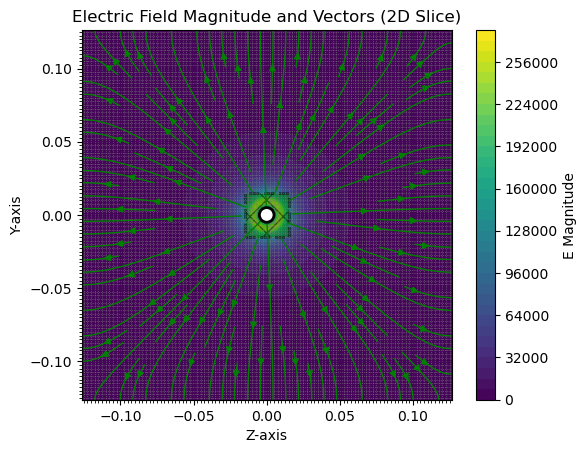

In [32]:
#Show gaussian surfaces
#((z1,y1),(z2,y2))
pos_gauss_surf = ((-0.075, -0.15,),(-0.055, 0.15))
neg_gauss_surf = ((0.055, -0.06),(0.075, 0.06)) # symmetric top to bottom
ball_gauss_surf = ((-0.015, -0.015),(0.015, 0.015))#Symmetric middle
nothing_gauss_surf = ((-0.04, -0.06),(-0.02, 0.06))

fig, ax = plt.subplots()
ax = plot_field(ax)
#ax = gauss_surf(ax, pos_gauss_surf)
#ax = gauss_surf(ax, neg_gauss_surf)
ax = gauss_surf(ax, ball_gauss_surf)
#ax = gauss_surf(ax, nothing_gauss_surf)
plt.show()

In [33]:
np.arange(1,3)

array([1, 2])

In [34]:
def Int_EdA_face(E_vec, Na, Nb):
    """Function calcs integral of E.dA for one face of a cube
    The surface normal of cube face is in direction of E_vec component
    The Tuples define the area of the face in directions orthogonal to N.

    Input should be eg. Ez[Nz[0]], (Ny1, Ny2), (Nx1, Nx2)

    edge_factor compensates for edges and corners.
    """
    flux = 0
    #For each surface pixel in face
    
    for i in np.arange(Na[0], Na[1]+1):
        for j in np.arange(Nb[0], Nb[1]+1):
            if (i==Na[0] or i ==Na[1]) and (j==Nb[0] or j ==Nb[1]):
                edge_factor = 0.25
            elif (i==Nb[0] or i ==Nb[1]) or (j==Nb[0] or j ==Nb[1]):
                edge_factor = 0.5
            else:
                edge_factor = 1
        
            flux += (edge_factor*E_vec[i, j]*dx**2)
    return flux


def calc_charge(coords, E):
    """
    To calc charge we take region which defines a cube in real coords.
    ((bottomlefty, bottomleftz),(toprighty, toprightz))
    x is assumed to be identical to y by symmetry
    Calc flux through each face and then multiply by eps0 to get Q in nC
    """
    Nx, Ny, Nz = coords 
    Ex,Ey,Ez = E
    
    flux = 0
    #dA is negative surface vector
    flux -= Int_EdA_face(Ex[Nx[0]], Ny, Nz)
    flux -= Int_EdA_face(Ey[:,Ny[0],:], Nz, Nx)
    flux -= Int_EdA_face(Ez[:,:,Nz[0]], Ny, Nx)
    
    #dA is positive surface vector
    flux += Int_EdA_face(Ex[Nx[1]], Nz, Ny)
    flux += Int_EdA_face(Ey[:,Ny[1],:], Nx, Nz)
    flux += Int_EdA_face(Ez[:,:,Nz[1]], Ny, Nx)   
    
    Q = flux * 8.854E-12 / 1E-9
    return Q

def charge_distribution_plate(E, plate, sim):
    """This function assumes the plates are vertical"""
    charge_z = []
    box = ((plate['Z']-sim['dz']-2*plate['t_plate'],plate['Lbottom']),(plate['Z']-sim['dz']+2*plate['t_plate'], plate['Ltop']))
    coords = abscoord_to_grididx(box, sim)
    top = plate['Ltop']
    for coord in range(coords[0][1], coords[1][1]):
        section = ((coords[0][0],coord),(coords[1][0], coord+1))
        charge_z.append(calc_charge(section, E))
    return charge_z

def get_grid_coords(region):
    Ny = (abscoord_to_grididx(region[0][1], sim), abscoord_to_grididx(region[1][1], sim))
    Nz = (abscoord_to_grididx(region[0][0], sim), abscoord_to_grididx(region[1][0], sim))
    Nx = Ny
    return (Nx, Ny, Nz)





In [35]:
#if plates:
#    pos_coords = get_grid_coords(pos_gauss_surf)
#    Q_nC = calc_charge(pos_coords)
#    print(f"Charge on +ve plate = {Q_nC}nC")
#    neg_coords = get_grid_coords(neg_gauss_surf)
#    Q_nC = calc_charge(neg_coords)
#    print(f"Charge on -ve plate = {Q_nC}nC")
if ball:
    ball_coords = get_grid_coords(ball_gauss_surf)
    print(ball_coords)
    E=(Ex,Ey,Ez)
    Q_nC = calc_charge(ball_coords, E)
    print(f"Charge on ball = {Q_nC}nC")
#nothing_coords = get_grid_coords(nothing_gauss_surf)
#Q_nC = calc_charge(nothing_coords)
#print(f"Charge on nothing = {Q_nC}nC")

#Analytical calc for ball based on what we put in
print(f"Added {Q}nC to ball")

Qz = charge_distribution_plate(E, lh_plate, sim)
num_pts = len(Qz)
z = np.linspace(0,num_pts, num=num_pts+1)
Qz=np.array(Qz)
plt.plot(z, Qz)


((44, 56), (44, 56), (44, 56))
Charge on ball = 2.9902637192036807nC
Added 3e-09nC to ball


KeyError: 't_plate'